### libs and defs


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import skrf as rf
import skrf.plotting as skplt
from skrf.data import ring_slot
import plotly.graph_objects as go

# Load the S-parameter file
bjt = rf.Network('Sparam-partI.s2p', )
# Load the S-parameter file
bjt = rf.Network('Sparam-partI.s2p', )
s = bjt.s.copy()
s[:,0,1], s[:,1,0] = s[:,1,0].copy(), s[:,0,1].copy()
bjt.s = s

# Filter for 4 GHz
freq_idx = np.where(np.isclose(bjt.f, 4e9, atol=1e7))[0][0]
freq_point = bjt[freq_idx]
print(f"Frequency point at 4 GHz:\n{freq_point}")

# Define a function to calculate the square of the absolute value


def sqabs(x): return np.square(np.absolute(x))

Frequency point at 4 GHz:
2-Port Network: 'Sparam-partI_subset',  3993913009.76755-3993913009.76755 Hz, 1 pts, z0=[50.+0.j 50.+0.j]


In [3]:
# show  the information of the network
bjt

2-Port Network: 'Sparam-partI',  1000000000.0-10000000000.0 Hz, 1002 pts, z0=[50.+0.j 50.+0.j]

In [4]:
# Plot the S-parameters
# bjt.s

In [5]:
# show the frequency points
# bjt.frequency.f_scaled

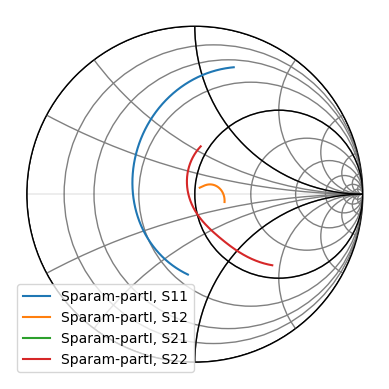

In [6]:
bjt.plot_s_smith()

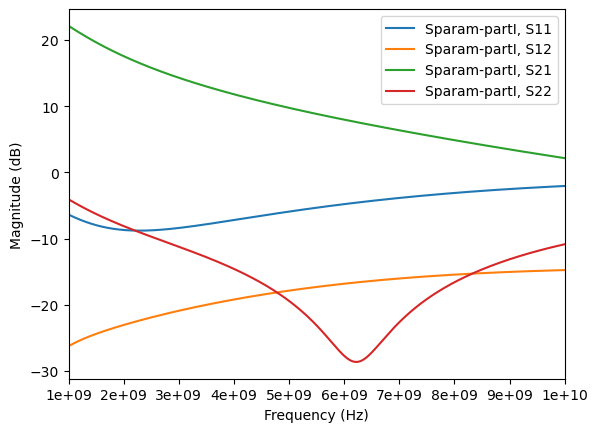

In [7]:
# plot the S-parameters in dB
bjt.plot_s_db()

In [8]:
# plot the S-parameters in dB for the frequency range 3-5 GHz
# bjt['3-5ghz'].plot_s_db()

In [9]:
# plot phase of S-parameters in degrees
# bjt.plot_s_deg()

### Bias


In [10]:
from sympy import solve, symbols, pprint
r1, r2, r3, r4, b, vbe, vce, vcc, ib, ic, ie = symbols(
    'R_1 R_2 R_3 R_4 beta V_{BE} V_{CE} V_{CC} I_b I_C I_E')


r2 = 1e3
r4 = 100
vcc = 10
b = 72.534
ic = 9e-3
vbe = 1
vce = 5

ib = ic/b
ie = (b+1)*ib
eq1 = vcc - r3*ic-r4*ie-vce
vth = vcc*(r2/(r1+r2))
rth = (r1*r2)/(r1+r2)
eq2 = -vth + ib*rth+vbe+ie*r4

s = solve([eq1, eq2], [r1, r3])
pprint(s)

{R₁: 3971.3433878574, R₃: 454.17689175651}


### Stability


/tmp/ipykernel_3673/3238084178.py:13: RuntimeWarning: invalid value encountered in sqrt
  MAG = np.abs(bjt.s21.s/bjt.s12.s) * (k-np.sqrt(np.square(k)-1))


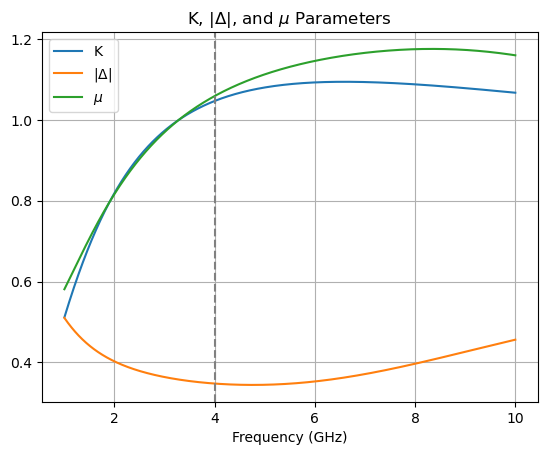

In [11]:
# delta is the determinant of the S-parameter matrix
delta = bjt.s11.s * bjt.s22.s - bjt.s12.s * bjt.s21.s

# k calculation
k = (1 - sqabs(bjt.s11.s) - sqabs(bjt.s22.s) + sqabs(delta)) / \
    (2 * np.abs(bjt.s12.s * bjt.s21.s))

# mu calculation
mu = (1 - sqabs(bjt.s11.s)) / (np.abs(bjt.s22.s -
                                      (delta*np.conj(bjt.s11.s)))+np.abs(bjt.s21.s*bjt.s12.s))

# Maximum available gain (MAG) calculation
MAG = np.abs(bjt.s21.s/bjt.s12.s) * (k-np.sqrt(np.square(k)-1))

k = np.squeeze(k)  # Remove any singleton dimensions
delta = np.squeeze(delta)  # Remove any singleton dimensions
mu = np.squeeze(mu)  # Remove any singleton dimensions
MAG = np.squeeze(MAG)  # Remove any singleton dimensions

# Plotting k values
plt.figure()
plt.plot(bjt.f/1e9, k)
plt.plot(bjt.f/1e9, np.abs(delta))
plt.plot(bjt.f/1e9, mu)
# add line in 4 Ghz
plt.axvline(x=4, color='gray', linestyle='--')
plt.title('K, |$\\Delta$|, and $\\mu$ Parameters')
plt.xlabel('Frequency (GHz)')

plt.grid()
plt.legend(['K', '|$\\Delta$|', '$\\mu$'])
plt.show()

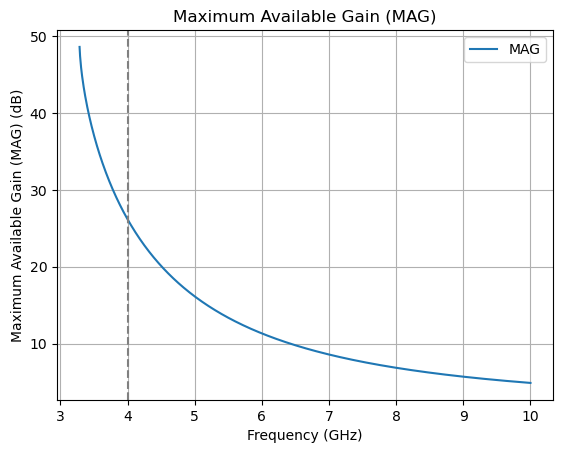

MAG at 4 GHz: 26.27 dB


In [12]:
# Plotting Maximum Available Gain (MAG)
plt.figure()
plt.plot(bjt.f/1e9, MAG)
# add line in 4 Ghz
plt.axvline(x=4, color='gray', linestyle='--')
plt.title('Maximum Available Gain (MAG)')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Maximum Available Gain (MAG) (dB)')
plt.grid()
plt.legend(['MAG'])
plt.show()

# Print MAG at 4 Ghz
val = MAG[np.where(np.isclose(bjt.f, 4e9, atol=1e7))]
print(f'MAG at 4 GHz: {val[0]:.2f} dB')

In [13]:
# Calculate stability circles
def sqabs(x): return np.square(np.absolute(x))  # noqa: E731


delta = bjt.s11.s*bjt.s22.s - bjt.s12.s*bjt.s21.s
rl = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s22.s) - sqabs(delta)))
cl = np.conj(bjt.s22.s - delta*np.conj(bjt.s11.s)) / \
    (sqabs(bjt.s22.s) - sqabs(delta))

rs = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s11.s) - sqabs(delta)))
cs = np.conj(bjt.s11.s - delta*np.conj(bjt.s22.s)) / \
    (sqabs(bjt.s11.s) - sqabs(delta))


def calc_circle(c, r):
    theta = np.linspace(0, 2*np.pi, 1000)
    return c + r*np.exp(1.0j*theta)

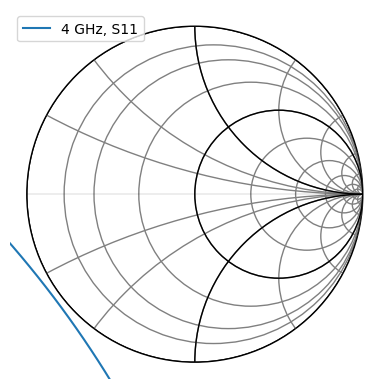

In [14]:
# Plot all the stability circles for source
# for i, f in enumerate(bjt.f):
#     # decimate it a little
#     if i % 100 != 0:
#         continue
#     n = rf.Network(name=str(f/1.e+9), s=calc_circle(cs[i][0, 0], rs[i][0, 0]))
#     n.plot_s_smith()

# Plot the stability circles at 4 GHz of source
myfreq = rf.Network(name='4 GHz', s=calc_circle(
    cs[freq_idx][0, 0], rs[freq_idx][0, 0]))
myfreq.plot_s_smith()

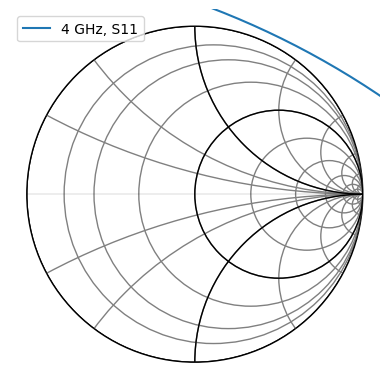

In [15]:
# Ploat all the stability circles for load
# for i, f in enumerate(bjt.f):
#     # decimate it a little
#     if i % 100 != 0:
#         continue
#     t = rf.Network(name=str(f/1.e+9), s=calc_circle(cl[i][0, 0], rl[i][0, 0]))
#     t.plot_s_smith()

# Plot the stability circles at 4 GHz of load
myfreq = rf.Network(name='4 GHz', s=calc_circle(
    cl[freq_idx][0, 0], rl[freq_idx][0, 0]))
myfreq.plot_s_smith()

In [16]:
# idx_4ghz = rf.util.find_nearest_index(bjt.f, 4.e+9)
# print(bjt.f[freq_idx])  # This should be close to 4 GHz

# # we need the normalized equivalent noise and optimum source coefficient to calculate the constant noise circles
# rn = bjt.rn[freq_idx]/50
# gamma_opt = bjt.g_opt[freq_idx]
# fmin = bjt.nfmin[freq_idx]

# for nf_added in [0, 0.1, 0.2, 0.5]: #this is the noise figure added in dB
#     nf = 10**(nf_added/10) * fmin

#     N = (nf - fmin)*abs(1+gamma_opt)**2/(4*rn)
#     c_n = gamma_opt/(1+N)
#     r_n = 1/(1-N)*np.sqrt(N**2 + N*(1-abs(gamma_opt)**2))

#     n = rf.Network(name=str(nf_added), s=calc_circle(c_n, r_n))
#     n.plot_s_smith()

# print("the optimum source reflection coefficient is ", gamma_opt)

In [17]:
# gamma_s = 0.0

# gamma_l = np.conj(bjt.s22.s - bjt.s21.s*gamma_s *
#                   bjt.s12.s/(1-bjt.s11.s*gamma_s))
# gamma_l = gamma_l[idx_4ghz, 0, 0]
# is_gamma_l_stable = np.absolute(gamma_l - cl[idx_4ghz]) > rl[idx_4ghz]

# gamma_l, is_gamma_l_stable

### Calc $\rho_L$ and $\rho_S$ and $\Z_L$ and $\Z_S$


In [18]:
# Calcular B1, B2, C1 e C2
print("Frequency (GHz):", bjt.f[freq_idx] / 1e9)
delta4GHz = delta[freq_idx]
print('delta4GHz:', delta4GHz)

# S11 and S22 for 4 GHz
s11 = freq_point.s11.s[0, 0]
s22 = freq_point.s22.s[0, 0]
s12 = freq_point.s12.s[0, 0]
s21 = freq_point.s21.s[0, 0]
print('S11:', s11)
print('S22:', s22)
print('S12:', s12)
print('|s11|: ', np.abs(s11))
print('|s22|: ', np.abs(s22))
print('|s12|: ', np.abs(s12))

B1 = 1 + sqabs(s11) - sqabs(s22) - sqabs(delta4GHz)
print('B1:', B1)
B2 = 1 + sqabs(s22) - sqabs(s11) - sqabs(delta4GHz)
print('B2:', B2)
C1 = s11 - (delta4GHz * np.conj(s22))
print('C1:', C1)
C2 = s22 - (delta4GHz * np.conj(s11))
print('C2:', C2)

# Calcular ros (ρs) e rol (ρL)
ros = (B1 - np.sqrt(np.square(B1) - 4 * sqabs(C1))) / (2 * C1)
rol = (B2 - np.sqrt(np.square(B2) - 4 * sqabs(C2))) / (2 * C2)
print("ros (ρs):", ros)
print("rol (ρL):", rol)
zs = (1 + ros) / (1 - ros)
zl = (1 + rol) / (1 - rol)
print("zs:", zs)
print("zl:", zl)

Frequency (GHz): 3.99391300976755
delta4GHz: [[-0.03322133-0.34631638j]]
S11: [-0.34038455+0.27382311j]
S22: [0.06099101-0.17707879j]
S12: [0.09275222+0.05840002j]
|s11|:  [0.43685322]
|s22|:  [0.18728802]
|s12|:  [0.10960628]
B1: [[1.03472524]]
B2: [[0.72319737]]
C1: [[-0.39968363+0.30082809j]]
C2: [[0.14451242-0.3040563j]]
ros (ρs): [[-0.61551748-0.46327879j]]
rol (ρL): [[0.29278313+0.61602013j]]
zs: [[0.14392195-0.32804026j]]
zl: [[0.60797527+1.4006243j]]


In [19]:
# delta calculation for 4 GHz
delta4 = s11*s22- s12*s21
# k calculation for 4 GHz
k4 = (1 - sqabs(s11) - sqabs(s22) + sqabs(delta4)) / \
    (2 * np.abs(s12 * s21))
print("k (4 GHz):", k4)
#maximum transducer gain
GTUmax = (1)/(1-sqabs(s11))*sqabs(21)*(1)/(1-sqabs(s22))
print("Maximum Transducer Gain (GTUmax):", GTUmax)

#maximum transducer power gain
GTmax = (np.abs(s21))/(np.abs(s12))*(k4 - np.sqrt(np.square(k4) - 1))
print("Maximum Transducer Power Gain (GTmax):", GTmax)

#maximum stable gain
Gmsg = (np.abs(s21))/(np.abs(s12))
print("Maximum Stable Gain (Gmsg):", Gmsg)

k (4 GHz): [1.04653976]
Maximum Transducer Gain (GTUmax): [564.82229641]
Maximum Transducer Power Gain (GTmax): [26.26849189]
Maximum Stable Gain (Gmsg): [35.59796805]


In [20]:
fig = go.Figure()
fig.add_trace(go.Scattersmith(
    real=[float(np.real(zs[0,0]))],
    imag=[float(np.imag(zs[0,0]))],
    mode="markers",
    marker=dict(color="blue", size=8),
    name=f"Zs* = {(zs[0,0]):.2f}"
))
fig.add_trace(go.Scattersmith(
    real=[float(np.real(zl[0,0]))],
    imag=[float(np.imag(zl[0,0]))],
    mode="markers",
    marker=dict(color="red", size=8),
    name=f"Zl* = {zl[0,0]:.2f}"
))
fig.update_layout(
    showlegend=True,
    width=600,
    height=600,
    title="Source and load conjugate impedances at 4 GHz",
    title_x=0.5,
    legend=dict(
        x=1.05,
        y=1.08,
        xanchor='right',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.7)'
    )
)
fig.show()

### Calc matching source and load circuit with Lumped elements in L


In [22]:

def calc_lumped_matching_circuits(f, z0, rl, xl):
    zl = rl + 1j*xl
    zl = np.conj(zl)
    rl = np.real(zl)
    xl = np.imag(zl)
    if rl > 1:
        b1 = (xl + (np.sqrt(rl/z0)*np.sqrt(np.square(rl) +
              np.square(xl)-z0*rl)))/(np.square(rl)+np.square(xl))
        b2 = (xl - (np.sqrt(rl/z0)*np.sqrt(np.square(rl) +
              np.square(xl)-z0*rl)))/(np.square(rl)+np.square(xl))

        xa = 1/b1 + (xl*z0/rl) - (z0/(b1*rl))
        x1 = xa
        x2 = - xa

        if b1 > 0:
            bmais = b1
            bmenos = b2
        else:
            bmais = b2
            bmenos = b1
        if x1 > 0:
            xmais = x1
            xmenos = x2
        else:
            xmais = x2
            xmenos = x1
        print("------------------------------------")
        print("Z0 - Xserie + Bparalelo - Z")
        print("B+ = ", bmais)
        print("X+ = ", xmais)
        print("B- = ", bmenos)
        print("X- = ", xmenos)
        print("------------------------------------")
        z0 = 50
        L_serie = xmais*z0/(2*np.pi*f)
        C_paralelo = bmais/(2*np.pi*f*z0)
        L_paralelo = -z0/(bmenos*2*np.pi*f)
        C_serie = -1/(z0*xmenos*2*np.pi*f)
        print("L_serie = ", L_serie)
        print("C_paralelo = ", C_paralelo)
        print("L_paralelo = ", L_paralelo)
        print("C_serie = ", C_serie)
        print("------------------------------------")
    else:
        xa = np.sqrt(rl*(z0-rl))
        if (xl < 0):
            xmenos = -np.abs(xa - xl)
            xmais = np.abs(-xa - xl)
        else:
            xmenos = -xa - xl
            xmais = xa - xl

        ba = np.sqrt((z0-rl)/rl)/z0
        bmais = ba
        bmenos = -ba

        print("------------------------------------")
        print("Z0 - Bparalelo + Xserie - Z")
        print("X+ = ", xmais)
        print("X- = ", xmenos)
        print("B+ = ", bmais)
        print("B- = ", bmenos)
        print("------------------------------------")
        z0 = 50
        L_serie = xmais*z0/(2*np.pi*f)
        C_paralelo = bmais/(2*np.pi*f*z0)
        L_paralelo = -z0/(bmenos*2*np.pi*f)
        C_serie = -1/(z0*xmenos*2*np.pi*f)
        print("L_serie = ", L_serie)
        print("C_paralelo = ", C_paralelo)
        print("L_paralelo = ", L_paralelo)
        print("C_serie = ", C_serie)
        print("------------------------------------")
    return


f = freq_point.f[0]
rs = np.real(zs)
xs = np.imag(zs)
rl = np.real(zl)
xl = np.imag(zl)
z0 = 1

print("------------------------------------")
print("Calc source matching circuit")
calc_lumped_matching_circuits(f, z0, rs, xs)
print("------------------------------------")
print("Calc load matching circuit")
calc_lumped_matching_circuits(f, z0, rl, xl)

------------------------------------
Calc source matching circuit
------------------------------------
Z0 - Bparalelo + Xserie - Z
X+ =  [[0.02297031]]
X- =  [[-0.67905083]]
B+ =  [[2.43889535]]
B- =  [[-2.43889535]]
------------------------------------
L_serie =  [[4.57676312e-11]]
C_paralelo =  [[1.94376918e-12]]
L_paralelo =  [[8.16955439e-10]]
C_serie =  [[1.17367875e-12]]
------------------------------------
------------------------------------
Calc load matching circuit
------------------------------------
Z0 - Bparalelo + Xserie - Z
X+ =  [[0.91242215]]
X- =  [[-1.88882645]]
B+ =  [[0.80299672]]
B- =  [[-0.80299672]]
------------------------------------
L_serie =  [[1.81797269e-09]]
C_paralelo =  [[6.39978374e-13]]
L_paralelo =  [[2.48129135e-09]]
C_serie =  [[4.21948522e-13]]
------------------------------------


### Calc impedance matching with lines and stubs


In [23]:
def calc_lines_stubs_circuit(z0, zl, f):
    # calc admitance
    y0 = 1/z0
    zl = zl*z0
    zl = np.conj(zl)
    rl = np.real(zl)
    xl = np.imag(zl)
    # shunt stubs
    print("------------------------------------")
    print("Calc shunt stubs")
    print("------------------------------------")

    t1 = (xl + np.sqrt(rl*(np.square(z0-rl)+np.square(xl))/z0))/(rl-z0)
    t2 = (xl - np.sqrt(rl*(np.square(z0-rl)+np.square(xl))/z0))/(rl-z0)
    print("t1:", t1)
    print("t2:", t2)

    t = t1
    # G1 = (rl*(1+np.square(t)))/(np.square(rl)+np.square(xl + z0*t))
    # print("G1:", G1)
    B1 = (np.square(rl)*t - (z0-xl*t)*(xl+z0*t)) / \
        (z0*(np.square(rl)+np.square(xl+z0*t)))
    print("B1:", B1)
    if t >= 0:
        d = ((1/(2*np.pi)*np.arctan(t)))/f
        if d < 0:
            d = d + 1/(2*f)
        print("d1:", d)
    else:
        d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
        if d < 0:
            d = d + 1/(2*f)
        print("d1:", d)

    t = t2
    # G2 = (rl*(1+np.square(t)))/(np.square(rl)+np.square(xl + z0*t))
    # print("G2:", G2)
    B1 = (np.square(rl)*t - (z0-xl*t)*(xl+z0*t)) / \
        (z0*(np.square(rl)+np.square(xl+z0*t)))
    print("B2:", B2)
    if t >= 0:
        d = (1/(2*np.pi)*np.arctan(t))/f
        if d < 0:
            d = d + 1/(2*f)
        print("d2:", d)
    else:
        d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
        if d < 0:
            d = d + 1/(2*f)
        print("d2:", d)

    # open circuit
    print(">>>>>>> Open circuit")
    l1 = (-1/(2*np.pi)*np.arctan(B1/y0))/f
    if l1 < 0:
        l1 = l1 + 1/(2*f)
    print("l1:", l1)
    l2 = (-1/(2*np.pi)*np.arctan(B2/y0))/f
    if l2 < 0:
        l2 = l2 + 1/(2*f)
    print("l2:", l2)
    # short circuit
    print(">>>>>>> Short circuit")
    l1 = (1/(2*np.pi)*np.arctan(y0/B1))/f
    if l1 < 0:
        l1 = l1 + 1/(2*f)
    print("l1:", l1)
    l2 = (1/(2*np.pi)*np.arctan(y0/B2))/f
    if l2 < 0:
        l2 = l2 + 1/(2*f)
    print("l2:", l2)

    # #series stubs
    # print("------------------------------------")
    # print("Calc series stubs")
    # print("------------------------------------")
    # yl = 1/zl
    # gl = np.real(yl)
    # bl = np.imag(yl)

    # t1 = (bl + np.sqrt(gl*((np.square(y0-gl)+np.square(bl)))/y0))/(gl-y0)
    # print("t1:", t1)
    # t2 = (bl - np.sqrt(gl*((np.square(y0-gl)+np.square(bl)))/y0))/(gl-y0)
    # print("t2:", t2)

    # t = t1
    # if t >= 0:
    #     d = (1/(2*np.pi)*np.arctan(t))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # else:
    #     d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # R1 = (gl*(1+np.square(t)))/(np.square(gl)+np.square(bl + y0*t))
    # print("R1:", R1)
    # X1 = (np.square(gl)*t - (y0-bl*t)*(bl+y0*t))/(y0*(np.square(gl)+np.square(bl+y0*t)))
    # print("X1:", X1)

    # t= t2
    # if t >= 0:
    #     d = (1/(2*np.pi)*np.arctan(t))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # else:
    #     d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # R2 = (gl*(1+np.square(t)))/(np.square(gl)+np.square(bl + y0*t))
    # print("R2:", R2)
    # X2 = (np.square(gl)*t - (y0-bl*t)*(bl+y0*t))/(y0*(np.square(gl)+np.square(bl+y0*t)))
    # print("X2:", X2)
    # #short circuit
    # print(">>>>>>> Short circuit")
    # l1 = (-1/(2*np.pi)*np.arctan(X1/z0))/f
    # if l1 < 0:
    #     l1 = l1 + 1/(2*f)
    # print("l1:", l1)
    # l2 = (-1/(2*np.pi)*np.arctan(X2/z0))/f
    # if l2 < 0:
    #     l2 = l2 + 1/(2*f)
    # print("l2:", l2)
    # #open circuit
    # print(">>>>>>> Open circuit")
    # l1 = (1/(2*np.pi)*np.arctan(z0/X1))/f
    # if l1 < 0:
    #     l1 = l1 + 1/(2*f)
    # print("l1:", l1)
    # l2 = (1/(2*np.pi)*np.arctan(z0/X2))/f
    # if l2 < 0:
    #     l2 = l2 + 1/(2*f)
    # print("l2:", l2)


print("------------------------------------")
print("Calc source matching circuit")
calc_lines_stubs_circuit(50, zs, f)
print("\n------------------------------------")
print("Calc loud matching circuit")
calc_lines_stubs_circuit(50, zl, f)

------------------------------------
Calc source matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: [[-0.78945882]]
t2: [[0.0230795]]
B1: [[0.04833149]]
d1: [[4.15281626e-11]]
B2: [[0.72319737]]
d2: [[9.19540323e-13]]
>>>>>>> Open circuit
l1: [[4.69602071e-11]]
l2: [[6.36970066e-11]]
>>>>>>> Short circuit
l1: [[1.09555461e-10]]
l2: [[1.10175241e-12]]

------------------------------------
Calc loud matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: [[0.67992517]]
t2: [[6.46566643]]
B1: [[0.03730668]]
d1: [[2.37950783e-11]]
B2: [[0.72319737]]
d2: [[5.64804755e-11]]
>>>>>>> Open circuit
l1: [[4.29851145e-11]]
l2: [[6.36970066e-11]]
>>>>>>> Short circuit
l1: [[1.05580369e-10]]
l2: [[1.10175241e-12]]


### Results


Frequency point at 4 GHz:
2-Port Network: 'Sparam-LCmatched_subset',  3990249023.61949-3990249023.61949 Hz, 1 pts, z0=[50.+0.j 50.+0.j]


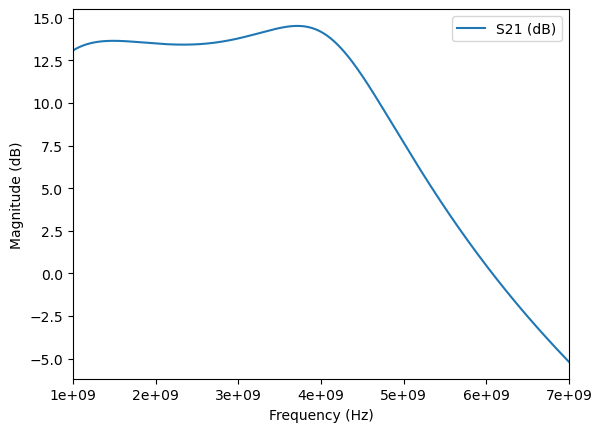

In [24]:
# Results for the LC matching circuit

LNA_LC = rf.Network('Sparam-LCmatched.s2p', )

# Load the S-parameter file
s = LNA_LC.s.copy()
s[:,0,1], s[:,1,0] = s[:,1,0].copy(), s[:,0,1].copy()
LNA_LC.s = s

# Filter for 4 GHz
freq_idx = np.where(np.isclose(LNA_LC.f, 4e9, atol=1e7))[0][0]
freq_point = LNA_LC[freq_idx]
print(f"Frequency point at 4 GHz:\n{freq_point}")

LNA_LC.s21.plot_s_db(label='S21 (dB)')

freq = '3990249023.61949'

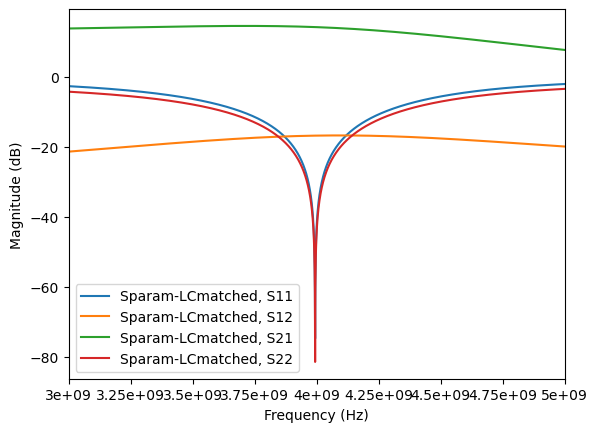

In [25]:
# plot matched S-parameters in dB
LNA_LC['3-5ghz'].plot_s_db()

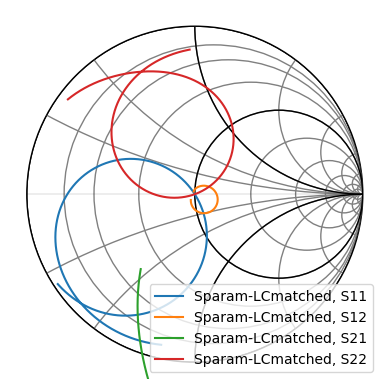

In [26]:
# plot the S-parameters in dB in the smith chart
LNA_LC.plot_s_smith()

In [1]:
# lgc = LNA_LC[freq].gain_circle(target_port=1, gain=-1.0)
# rf.plotting.plot_smith(s=lgc, smith_r=1)

# plt.show()

In [28]:
LNA_LC[freq].max_stable_gain

array([35.65435245])

In [29]:
LNA_LC[freq].max_gain

array([26.32063151])

In [31]:
LNA_LC[freq].stability #k factor

array([1.04641633])

In [32]:
# Calculate the noise figure
# 10*np.log10(LNA_LC.nf(50.)[freq_idx])

Frequency point at 4 GHz:
2-Port Network: 'Sparam-LSmatched_subset',  3990249023.61949-3990249023.61949 Hz, 1 pts, z0=[50.+0.j 50.+0.j]


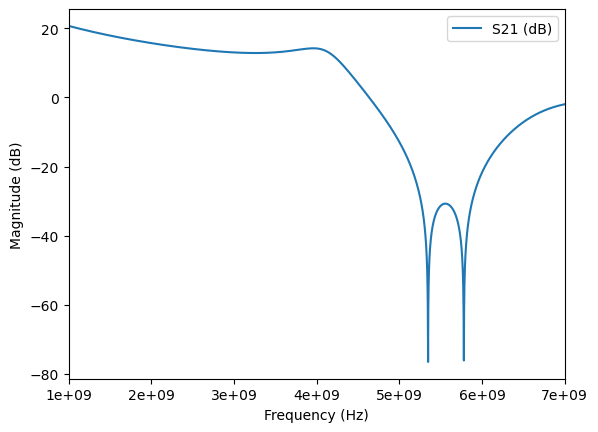

In [33]:
# Results for the LS matching circuit

LNA_LS = rf.Network('Sparam-LSmatched.s2p', )

# Load the S-parameter file
s = LNA_LS.s.copy()
s[:,0,1], s[:,1,0] = s[:,1,0].copy(), s[:,0,1].copy()
LNA_LS.s = s

# Filter for 4 GHz
freq_idx = np.where(np.isclose(LNA_LS.f, 4e9, atol=1e7))[0][0]
freq_point = LNA_LS[freq_idx]
print(f"Frequency point at 4 GHz:\n{freq_point}")

LNA_LS.s21.plot_s_db(label='S21 (dB)')

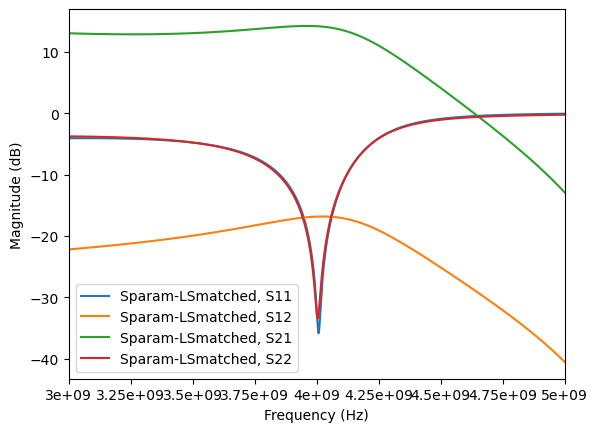

In [34]:
# plot the S-parameters in dB
LNA_LS['3-5ghz'].plot_s_db()

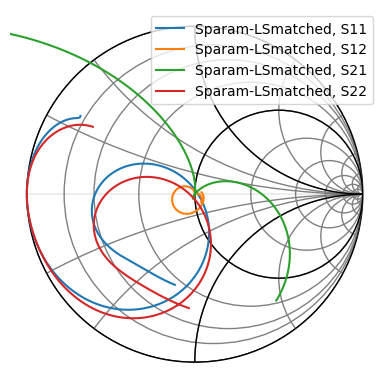

In [35]:
# Plot the S-parameters in the smith chart
LNA_LS.plot_s_smith()

In [36]:
# Calculate the noise figure
# 10*np.log10(LNA_LS.nf(50.)[freq_idx])